In [1]:
from matplotlib import pyplot
from atmos_cloud_sim_uj_utils import show_plot
from PySDM.physics import constants as const
from PySDM import Formulae
import numpy as np
import pint
si = pint.UnitRegistry()
si.setup_matplotlib()

In [2]:
params = {
    'Illite': {'m': 54.48, 'c': -10.67, 'color': 'orange'},
    'Nonadecanol': {'m': 28.13797, 'c': -2.92414, 'color': 'brown'},
    'dust': {'m': 22.62, 'c': -1.35, 'color': 'teal'}
}

In [3]:
svp = Formulae(saturation_vapour_pressure='FlatauWalkoCotton').saturation_vapour_pressure
T = np.linspace(const.T0 - 12, const.T0 - 36) * si.K

def _T(T):
    return (T/si.K).to_base_units().magnitude

a_w_ice = svp.ice_Celsius(_T(T) - const.T0) / svp.pvs_Celsius(_T(T) - const.T0)

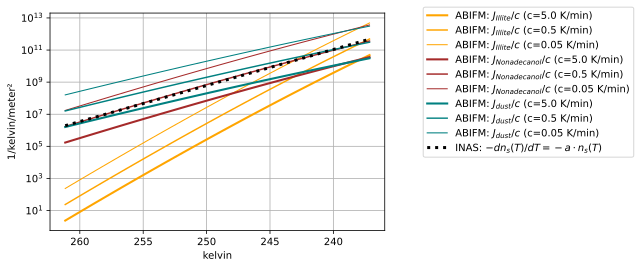

HTML(value="<a href='./INAS_vs_ABIFM.pdf' target='_blank'>./INAS_vs_ABIFM.pdf</a><br>")

In [4]:
cooling_rates = tuple((x*si.K/si.min).to_base_units() for x in (5, .5, .05))

for label, mc in params.items():
    formulae_abifm = Formulae(
        constants={
            'ABIFM_M': mc['m'],
            'ABIFM_C': mc['c']
        },
        heterogeneous_ice_nucleation_rate='ABIFM'
    )
    abifm_j_het = lambda T, formulae=formulae_abifm: (
        formulae.heterogeneous_ice_nucleation_rate.j_het(_T(T)) / si.m**2 / si.s
    )
    for c in cooling_rates:
        c_K_min = (c / si.K * si.min).to_base_units().magnitude
        pyplot.plot(T, abifm_j_het(a_w_ice) / c,
                    label=f'ABIFM: $J_{{{label}}}/c$ (c={c_K_min} K/min)',
                    color=mc['color'],
                    linewidth=3*c.magnitude**.15
                   )

formulae = Formulae(
    constants={
        'NIEMAND_A': -0.517,
        'NIEMAND_B': 8.934
    },
    freezing_temperature_spectrum='Niemand_et_al_2012'
)
inas_ns = lambda T: formulae.freezing_temperature_spectrum.ns(_T(T)) / si.m**2

a = formulae.constants.NIEMAND_A / si.K
pyplot.plot(T, -a*inas_ns(T), label=r'INAS: $-dn_{s}(T)/dT=-a \cdot n_s(T)$',
            color='black', linestyle=':', linewidth=3)

pyplot.gca().invert_xaxis()
pyplot.yscale('log')
pyplot.grid()
pyplot.legend(bbox_to_anchor=(1.1, 1.05))
show_plot('INAS_vs_ABIFM.pdf')